In [ ]:
# %%

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

import importlib
import preprocessing.pipeline
importlib.reload(preprocessing.pipeline)
from preprocessing.pipeline import get_preprocessor

# === Additional imports for cross-validation ===
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# %%

# === Import data ===
train = pd.read_csv("../data/train.csv")
X_test = pd.read_csv("../data/test.csv")

X_train = train.drop("SalePrice", axis=1)
y_train = train["SalePrice"]

In [ ]:
# %%

# === Build preprocessing + modeling pipeline ===
model_pipeline = Pipeline([
  ("preprocessor", get_preprocessor()),
  ("model", TransformedTargetRegressor(
		regressor=RandomForestRegressor(n_estimators=100, random_state=42),
		func=np.log1p,
		inverse_func=np.expm1
	))
])

In [ ]:
# %%

# === Hyperparameter Tuning with GridSearchCV ===
param_grid = {
  "model__regressor__n_estimators": [100], # 50, 200
  "model__regressor__max_depth": [None], # 10, 15, 20
  "model__regressor__max_features": [0.5] # "sqrt"
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
  model_pipeline,
  param_grid,
  cv=cv,
  scoring="neg_root_mean_squared_error",
  n_jobs=-1,
  verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator from the search for further evaluation
model_pipeline = grid_search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'model__regressor__max_depth': None, 'model__regressor__max_features': 0.5, 'model__regressor__n_estimators': 100}


In [ ]:
# %%

# === Fit on full training data ===
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('drop_id',
                                                   ColumnDropper(columns_to_drop=['Id'])),
                                                  ('cat_na_fill',
                                                   CategoricalNaFiller(excluded_cols=['GarageYrBlt'])),
                                                  ('num_na_fill',
                                                   NumericalNaFiller(excluded_cols=['LotFrontage'])),
                                                  ('garage_bin',
                                                   GarageYrBltBinner()),
                                                  ('remove_outliers',
                                                   OutlierRemover()),
                                                  ('skewed_transform',
                                                   SkewedFeatureTransformer())])),
                                 ('transformer', OneHotEncoderScaler()),
                                 ('lotfrontage_fill', LotFrontageFiller())])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(max_features=0.5,
                                                                            random_state=42)))])


=== Feature Importances ===


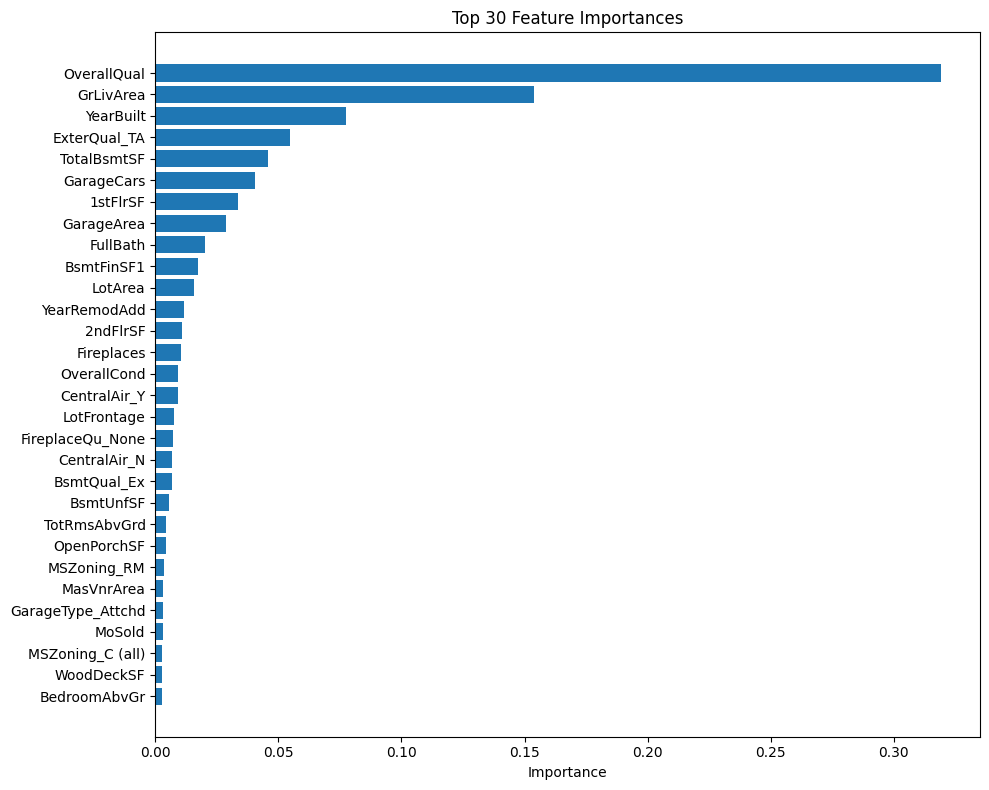

In [ ]:
# %%

# === Feature Importances ===
print("\n=== Feature Importances ===")
model = model_pipeline.named_steps["model"].regressor_
feature_names = model_pipeline.named_steps["preprocessor"].named_steps["transformer"].get_feature_names_out()
importances = model.feature_importances_

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
  "Feature": feature_names,
  "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df["Feature"][:30][::-1], feat_imp_df["Importance"][:30][::-1])
plt.xlabel("Importance")
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# %%

# === Predict on test data ===
y_test_pred = model_pipeline.predict(X_test)

In [ ]:
# %%

# === Wrap in DataFrame ===
submission = pd.DataFrame({
  "Id": X_test["Id"],  # assuming 'Id' is in test data
  "SalePrice": y_test_pred
})

submission.head()

,Id,SalePrice
0,1461,125841.922635
1,1462,153160.868519
2,1463,173598.873931
3,1464,185970.741996
4,1465,197498.007597


In [ ]:
# %%

# === Save in submission file ===
submission.to_csv("../data/submission.csv", index=False)

In [ ]:
# %%

# === Evaluate CV and Training Performance to Check Overfitting ===
from sklearn.model_selection import cross_val_predict

# Cross-validated predictions
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_preds = cross_val_predict(model_pipeline, X_train, y_train, cv=cv)

# CV Metrics
cv_log_rmse = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(cv_preds)))
cv_r2 = r2_score(y_train, cv_preds)

# Training Metrics
y_train_pred = model_pipeline.predict(X_train)
train_log_rmse = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(y_train_pred)))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train Log RMSE: {train_log_rmse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")

print("=== Cross-Validation Performance ===")
print(f"CV Log RMSE: {cv_log_rmse:.2f}")
print(f"CV R² Score: {cv_r2:.4f}")

print("\n=== Training Performance ===")
print(f"Train Log RMSE: {train_log_rmse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")

Train Log RMSE: 0.05
Train R² Score: 0.9811
=== Cross-Validation Performance ===
CV Log RMSE: 0.14
CV R² Score: 0.8658

=== Training Performance ===
Train Log RMSE: 0.05
Train R² Score: 0.9811
